In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from torch.utils.data import DataLoader, TensorDataset
import sys
if 'helpers' in sys.modules:
    del sys.modules['helpers']

from helpers import BinaryNetwork, train_model

sns.set()

## Cargamos el Dataset

In [16]:
df = pd.read_csv("../datasets/chicago_crimes_and_stations_2024_final.csv")
test_df = pd.read_csv("../datasets/chicago_crimes_and_stations_2024_final_test.csv")


X = df.drop(["Arrest_tag"], axis=1)
y = df["Arrest_tag"]

columns = len(list(X.columns))

X_test = test_df.drop(["Arrest_tag"], axis=1)
y_test = test_df["Arrest_tag"]

X = X.values.astype(float)
y = y.values.astype(float)

X_test = X_test.values.astype(float)
y_test = y_test.values.astype(float)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)

# Convertimos en tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Creamos usando DataLoader los sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [17]:
input_size = columns # número de características
architectures = [
    {
        'name': 'Baseline 32-16',
        'layers': torch.nn.Sequential(
            torch.nn.Linear(input_size, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1)
        )
    },
    {
        'name': 'BatchNorm 32-16',
        'layers': torch.nn.Sequential(
            torch.nn.BatchNorm1d(input_size),
            torch.nn.Linear(input_size, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1)
        )
    },
    {
        'name': 'Dropout 64-32',
        'layers': torch.nn.Sequential(
            torch.nn.Linear(input_size, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(32, 1)
        )
    },
    {
        'name': 'GELU 128-64',
        'layers': torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.GELU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 64),
            torch.nn.GELU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 1)
        )
    },
    {
        'name': 'Deep 128-64-32',
        'layers': torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(32, 1)
        )
    }
]

In [ ]:
# Entrenar múltiples arquitecturas
results = []

for i, arch in enumerate(architectures):
    print(f"\n{'='*50}")
    print(f"MODELO {i+1}/{len(architectures)}: {arch['name']}")
    print(f"{'='*50}")

    # Crear modelo
    model = BinaryNetwork(arch['layers'])
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Entrenar usando función de helpers.py
    history = train_model(
        model,
        train_loader,
        val_loader,
        loss_fn,
        optimizer,
        epochs=450,
        max_patience=5,
        patience_alpha=0.001,
        verbose=False,  # No imprimir cada época
        print_every=50
    )

    # Evaluar en test
    y_pred_list = []
    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            y_test_pred = model(X)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag)

    y_pred_tensor = torch.cat(y_pred_list).squeeze()
    test_acc = accuracy_score(y_test, y_pred_tensor)
    test_f1 = f1_score(y_test, y_pred_tensor)

    # Guardar resultados
    results.append({
        'Modelo': arch['name'],
        'Val Loss': f"{history['best_val_loss']:.4f}",
        'Val Acc': f"{history['best_val_acc']:.4f}",
        'Test Acc': f"{test_acc:.4f}",
        'Test F1': f"{test_f1:.4f}",
        'Épocas': history['epochs_trained']
    })

    print(f"✓ Val Acc: {history['best_val_acc']:.4f} | Test Acc: {test_acc:.4f} | F1: {test_f1:.4f} | Épocas: {history['epochs_trained']}")



RESUMEN COMPARATIVO DE ARQUITECTURAS

         Modelo Val Loss Val Acc Test Acc Test F1  Épocas
 Baseline 32-16   0.6013  0.6743   0.7765  0.3891      57
BatchNorm 32-16   0.4683  0.7656   0.7933  0.4456      77
  Dropout 64-32   0.5014  0.7469   0.7730  0.4359     144
    GELU 128-64   0.5117  0.7373   0.7550  0.4124     182
 Deep 128-64-32   0.4111  0.7981   0.7937  0.4729     112

🏆 MEJOR MODELO: Deep 128-64-32
   Test Accuracy: 0.7937
   Test F1:       0.4729
   Val Accuracy:  0.7981
   Épocas:        112


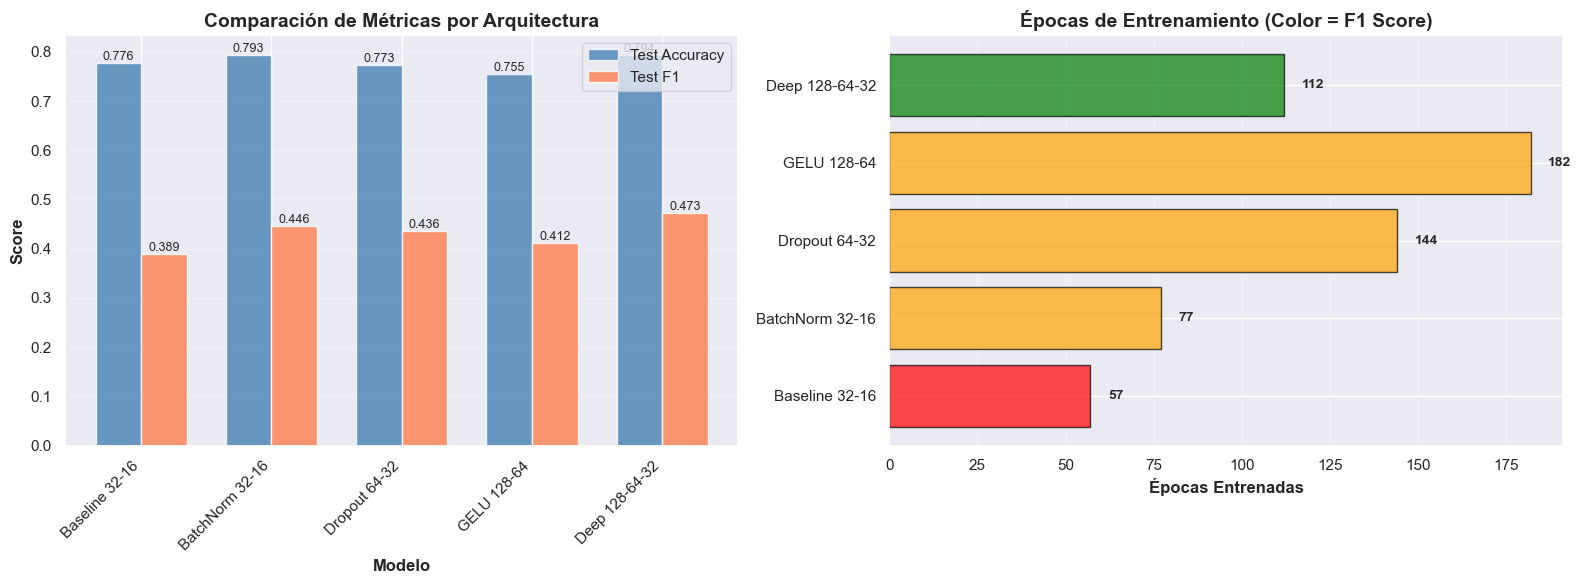

In [19]:
# ============================================
# RESUMEN FINAL
# ============================================

print(f"\n{'='*70}")
print("RESUMEN COMPARATIVO DE ARQUITECTURAS")
print(f"{'='*70}\n")

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Mejor modelo
best_idx = df_results['Test Acc'].astype(float).idxmax()
print(f"\n{'='*70}")
print(f"🏆 MEJOR MODELO: {df_results.loc[best_idx, 'Modelo']}")
print(f"{'='*70}")
print(f"   Test Accuracy: {df_results.loc[best_idx, 'Test Acc']}")
print(f"   Test F1:       {df_results.loc[best_idx, 'Test F1']}")
print(f"   Val Accuracy:  {df_results.loc[best_idx, 'Val Acc']}")
print(f"   Épocas:        {df_results.loc[best_idx, 'Épocas']}")

# Graficar comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Comparación de métricas
x = np.arange(len(df_results))
width = 0.35

test_acc_values = df_results['Test Acc'].astype(float).values
test_f1_values = df_results['Test F1'].astype(float).values

bars1 = axes[0].bar(x - width/2, test_acc_values, width, label='Test Accuracy', alpha=0.8, color='steelblue')
bars2 = axes[0].bar(x + width/2, test_f1_values, width, label='Test F1', alpha=0.8, color='coral')

axes[0].set_xlabel('Modelo', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación de Métricas por Arquitectura', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_results['Modelo'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Subplot 2: Épocas entrenadas
epochs_values = df_results['Épocas'].values
colors = ['green' if f > 0.45 else 'orange' if f > 0.40 else 'red' for f in test_f1_values]
bars = axes[1].barh(df_results['Modelo'], epochs_values, color=colors, alpha=0.7, edgecolor='black')

axes[1].set_xlabel('Épocas Entrenadas', fontsize=12, fontweight='bold')
axes[1].set_title('Épocas de Entrenamiento (Color = F1 Score)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Agregar valores
for i, (bar, val) in enumerate(zip(bars, epochs_values)):
    axes[1].text(val + 5, i, f'{val}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
